In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt

multimodal_large_train size:  10000
multimodal_large_test size:  1000


<Axes: >

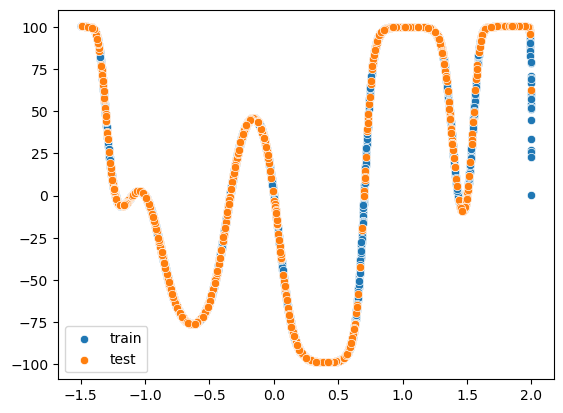

In [20]:
multimodal_large_train = pd.read_csv('../data/regression/multimodal-large-training.csv')[['x', 'y']]
multimodal_large_test = pd.read_csv('../data/regression/multimodal-large-test.csv')[['x', 'y']]

multimodal_large_train_X = np.array(multimodal_large_train['x'])
multimodal_large_train_Y = np.array(multimodal_large_train['y'])

multimodal_large_test_X = np.array(multimodal_large_test['x'])
multimodal_large_test_Y = np.array(multimodal_large_test['y'])


print('multimodal_large_train size: ', len(multimodal_large_train))
print('multimodal_large_test size: ', len(multimodal_large_test))

sns.scatterplot(x=multimodal_large_train_X, y=multimodal_large_train_Y, label = 'train')
sns.scatterplot(x=multimodal_large_test_X, y=multimodal_large_test_Y, label = 'test')

In [ ]:
def sigmoid(x):
	return 1/(1+np.e**(-x))

def sigmoid_derivative(x):
	return sigmoid(x) * (1 - sigmoid(x))

def linear(x):
	return x

def linear_derivative(x):
	return 1

def softmax(x):
    if x.ndim == 1:
        x = x.reshape(1, -1)  
    
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def tanh(x):
	return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def tanh_derivative(x):
	return 1 - tanh(x)**2

def ReLU(x):
	return np.maximum(0, x)

def ReLU_derivative(x):
	return np.where(x > 0, 1, 0)

class network:
	def __init__(self, architecture, activation_functions, activation_derivatives, initiation_method):
		self.architecture = architecture
		self.activation_functions = activation_functions
		self.activation_derivatives = activation_derivatives
		self.weights_biases_initiation(initiation_method)
		self.loss_record = []
		self.f1_score = []

	def set_state(self, architecture, biases, weights, activation_functions):
		self.architecture = architecture
		self.biases = biases
		self.weights = weights
		self.activation_functions = activation_functions

	def weights_biases_initiation(self, initiation_method):
		self.weights = [None]
		self.biases = [None]
		self.weights_momentum = [None]
		self.biases_momentum = [None]
		self.weigths_rmsProp = [None]
		self.biases_rmsProp = [None]

		if initiation_method not in ['he', 'xavier', 'uniform']:
			print('Initiation method incorrect!')
			return 

		for i in range(len(self.architecture) - 1):
			input_dim = self.architecture[i]
			output_dim = self.architecture[i + 1]
			
			if initiation_method == 'he':
				weight_matrix = np.random.randn(input_dim, output_dim) * np.sqrt(2 / input_dim)
			elif initiation_method == 'xavier':
				weight_matrix = np.random.randn(input_dim, output_dim) * np.sqrt(1 / input_dim)
			elif initiation_method == 'uniform':
				weight_matrix = np.random.uniform(0, 1, (input_dim, output_dim))

			bias_vector = np.zeros((1, output_dim))
			
			self.weights_momentum.append(np.zeros(weight_matrix.shape))
			self.biases_momentum.append(np.zeros(bias_vector.shape))
			self.weigths_rmsProp.append(np.zeros(weight_matrix.shape))
			self.biases_rmsProp.append(np.zeros(bias_vector.shape))
			self.weights.append(weight_matrix)
			self.biases.append(bias_vector)

	def forward(self, X):
		# as a convention, for convinience, zeroth index of activations is raw input, i add None to preactivations for uniform indexing
		self.activations = [X]
		self.preactivations = [None]

		for i in range(0, len(self.architecture)-1):
			z = np.dot(self.activations[i], self.weights[i+1]) + self.biases[i+1]
			self.preactivations.append(z)
			
			a = self.activation_functions[i+1](z)
			self.activations.append(a)
	
	def check_MSE(self, x, y):
		self.forward(x)
		prediction = self.destandardize_data(self.activations[-1], 'y')
		correct = self.destandardize_data(y, 'y')
		return np.mean((correct - prediction) ** 2)
	
	def check_categorical_crossentropy_loss(self, x, y, epsilon=1e-12):
		self.forward(x)
		prediction = self.activations[-1]
		prediction = np.clip(prediction, epsilon, 1.0 - epsilon)
		loss = -np.sum(y * np.log(prediction), axis=1)
		return np.mean(loss)

	def check_fmeasure(self, x, y):
		self.forward(x)
		prediction = np.argmax(self.activations[-1], axis=1)
		correct = np.argmax(y, axis=1)

		labels = np.unique(y)

		true_positives = np.zeros(len(labels))
		false_positives = np.zeros(len(labels))
		false_negatives = np.zeros(len(labels))

		for i, label in enumerate(labels):
			true_positives[i] = np.sum((prediction == label) & (correct == label))
			false_positives[i] = np.sum((prediction == label) & (correct != label))
			false_negatives[i] = np.sum((prediction != label) & (correct == label))

		precision = true_positives / (true_positives+false_positives + 1e-10)
		recall = true_positives / (true_positives+false_negatives + 1e-10)

		f1_per_class = 2 * (precision * recall) / (precision + recall + 1e-10)
		return np.mean(f1_per_class)
	
	def visualize_network(self):
		G = nx.DiGraph()
		pos = {}
		edge_colors = []
		edge_widths = []
		
		for layer_idx, num_nodes in enumerate(self.architecture):
			for node_idx in range(num_nodes):
				node_name = f"L{layer_idx}_N{node_idx}"
				pos[node_name] = (layer_idx, -node_idx)  
				G.add_node(node_name)
				
				if layer_idx > 0: 
					for prev_idx in range(self.architecture[layer_idx - 1]):
						prev_name = f"L{layer_idx-1}_N{prev_idx}"
						weight = self.weights[layer_idx][prev_idx][node_idx]

						if weight != 0:
							G.add_edge(prev_name, node_name)
							edge_colors.append('red' if weight < 0 else 'green')
							edge_widths.append(np.log(abs(weight)))
		
		plt.figure(figsize=(10, 5))
		nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", edge_color=edge_colors, width=edge_widths)
		plt.show()

	def backward(self, Y, task):
		self.error = [None] * (len(self.weights))
		self.weights_gradient = [None] * (len(self.weights))
		self.biases_gradient = [None] * (len(self.weights))

		# if task == 'regression':
		# 	self.error[-1] = (self.activations[-1] - Y) * self.activation_derivatives[-1](self.preactivations[-1])
		# if task == 'classification':
		# 	self.error[-1] = (self.activations[-1] - Y)
		
		# normalnie to to kwestia czy regresja czy klasyfikacja ale żeby spróbować klasyfikacji dla liniowej ostatniej warstywy robie tak 
		if self.activation_functions[-1] != softmax: 
			self.error[-1] = (self.activations[-1] - Y) * self.activation_derivatives[-1](self.preactivations[-1])
		else:
			self.error[-1] = (self.activations[-1] - Y)

		for i in reversed(range(1, len(self.error) - 1)):
			self.error[i] = np.dot(self.error[i+1], self.weights[i+1].T) * self.activation_derivatives[i](self.preactivations[i])
		
		for i in range(1, len(self.error)):
			# self.weights_gradient[i] = -step * np.dot(self.activations[i-1].T, self.error[i]) / self.error[i].shape[0]
			# self.biases_gradient[i] = (-step * np.mean(self.error[i], axis=0)).reshape(1, -1)
			self.weights_gradient[i] = np.dot(self.activations[i-1].T, self.error[i]) / self.error[i].shape[0]
			self.biases_gradient[i] = (np.mean(self.error[i], axis=0)).reshape(1, -1)

	def prepeare_batches(self, x, y, task, batch_size=None):
			n = len(x)
			if batch_size == None:
				batch_number = 1
			else:
				batch_number = int(np.ceil(n / batch_size))

			indices = np.random.permutation(n)
			x_shuffled = x[indices]
			y_shuffled = y[indices]

			x_batched = np.array_split(x_shuffled, batch_number)
			y_batched = np.array_split(y_shuffled, batch_number)

			return x_batched, y_batched, batch_number
		
	def prepare_data(self, x, y, task):
		if type(x) == list:
			input_size = len(x)
			for i in range(input_size):
				size = len(x[i])
				x[i] = np.reshape(x[i], (size, 1))
			x = np.hstack(x)
		else:
			x = np.reshape(x, (len(x), 1))
		
		y = np.reshape(y, (len(y), 1))

		x_standardized = self.standardize_data(x, 'x')

		if task == 'classification':
			labels = np.unique(y)
			label_to_index = {label: index for index, label in enumerate(labels)}
			indexes = np.array([label_to_index[label] for label in y.flatten()])

			labels_num = len(labels)
			y = np.eye(labels_num)[indexes]

			return x_standardized, y
		else:
			y_standardized = self.standardize_data(y, 'y')

			return x_standardized, y_standardized
	
	def learn_old(self, x, y, step, iterations):
		x = self.standardize_data(x, 'x')
		y = self.standardize_data(y, 'y')

		for e in range(iterations):
			self.forward(x)
			self.backward(y, step)
			
			for i in range(1, len(self.architecture)):
					self.weights[i] += self.weights_gradient[i]
					self.biases[i] += self.biases_gradient[i]

			self.mse_record.append(self.check_MSE(x, y))

	def learn(self, task, x, y, epochs_number, step, momentum_dumping=None, rmsprop_dumping=None, batch_size=None):
		if momentum_dumping != None and rmsprop_dumping != None:
			print('Both momentum and rmsProp parameters were passed! Choose one.')
			return 
		
		if task not in ['classification', 'regression']:
			print('Incorrect network task! Choose classification or regression.')
			return
		
		x, y = self.prepare_data(x, y, task)
		
		for e in range(epochs_number):
			x_batches, y_batches, batch_number = self.prepeare_batches(x, y, task, batch_size)

			for b in range(batch_number):
				self.forward(x_batches[b])
				self.backward(y_batches[b], task)

				for i in range(1, len(self.architecture)):
					if momentum_dumping == None and rmsprop_dumping == None:
						# simple learning
						self.weights[i] -= self.weights_gradient[i] * step
						self.biases[i] -= self.biases_gradient[i] * step

					elif momentum_dumping != None and rmsprop_dumping == None:
						# learning with momentum
						self.weights_momentum[i] = self.weights_momentum[i] * momentum_dumping - self.weights_gradient[i]
						self.biases_momentum[i] = self.biases_momentum[i] * momentum_dumping - self.biases_gradient[i]
						self.weights[i] += self.weights_momentum[i] * step
						self.biases[i] += self.biases_momentum[i] * step

					elif momentum_dumping == None and rmsprop_dumping != None:
						# learning with rmsProp
						epsilon = 1e-8
						self.weigths_rmsProp[i] = rmsprop_dumping * self.weigths_rmsProp[i] + (1 - rmsprop_dumping) * self.weights_gradient[i]**2
						self.biases_rmsProp[i] = rmsprop_dumping * self.biases_rmsProp[i] + (1 - rmsprop_dumping) * self.biases_gradient[i]**2
						self.weights[i] -= step/(np.sqrt(self.weigths_rmsProp[i] + epsilon)) * self.weights_gradient[i]
						self.biases[i] -= step/(np.sqrt(self.biases_rmsProp[i] + epsilon)) * self.biases_gradient[i]

			if task == 'regression':
				self.loss_record.append(self.check_MSE(np.vstack(x_batches), np.vstack(y_batches)))
			if task == 'classification':
				self.loss_record.append(self.check_categorical_crossentropy_loss(np.vstack(x_batches), np.vstack(y_batches)))
				self.f1_score.append(self.check_fmeasure(np.vstack(x_batches), np.vstack(y_batches)))

	def standardize_data(self, data, type):
		mean = np.mean(data, axis=0)
		std = np.std(data, axis=0)
		data_new = (data - mean) / std

		if type == 'x':
			self.standardize_params_x = (mean, std)
		if type == 'y':
			self.standardize_params_y = (mean, std)

		return data_new

	def destandardize_data(self, data, type):
		if type == 'x':
			return data * self.standardize_params_x[1] + self.standardize_params_x[0]
		if type == 'y':
			return data * self.standardize_params_y[1] + self.standardize_params_y[0]

def test_regression(x, y, size, network):
	x = x.reshape(size, 1)
	y = y.reshape(size, 1)
	x_std = (x - network.standardize_params_x[0]) / network.standardize_params_x[1]
	
	network.forward(x_std)
	y_pred_std = network.activations[-1]
	y_pred = network.destandardize_data(y_pred_std, 'y')

	print('test mse:', np.mean((y - y_pred) ** 2))
	plt.figure()
	sns.scatterplot(x=x.flatten(), y=y_pred.flatten(), alpha=0.8, label='Predicted')
	sns.scatterplot(x=x.flatten(), y=y.flatten(), alpha=0.8, label='Actual')

def test_classification(x, y, network):
	task = 'classification'

	x_prep, y_prep = network.prepare_data(x, y, task)

	print('test cross entropy:', network.check_categorical_crossentropy_loss(x_prep, y_prep))
	print('test f-measure:', network.check_fmeasure(x_prep, y_prep))
	classification = np.argmax(network.activations[-1], axis=1)

	fig, axes = plt.subplots(1, 2, figsize=(12, 5))
	sns.scatterplot(x=x[0].flatten(), y=x[1].flatten(), hue=classification, ax=axes[0], palette='Set1')
	axes[0].set_title("Predicted Classification")
	sns.scatterplot(x=x[0].flatten(), y=x[1].flatten(), hue=y.flatten(), ax=axes[1], palette='Set1')
	axes[1].set_title("True Classification")

In [ ]:
# Mamy do przeprowadzenia porównanie architektór 1,2 i 3 warstwowych (ukryte warstwy) dla aktywacji liniowych, sigmoidalnych, tanh oraz ReLU. Przyjmuję ograniczenie, że liczba neuronów w warstwach jest taka sama i ograniczam się do ilości; małej np. 5, średniej np.15 i dużej np.30. Wtedy mamy 3*4*3=36 testów. Hiperparametry będą stałe i początkowe wagi z rozkładu xavier. Sieci będą nazwane w konwencji: (lin/sig/tan/rel)_(w3/w2/w1)_(small/medium/big).

In [4]:
import itertools

activation_string = ['lin', 'sig', 'tan', 'rel']
layers_string = ['w3', 'w2', 'w1']
neurons_string = ['small', 'medium', 'big']

activation_dict = {'lin' : [linear, linear_derivative], 'sig' : [sigmoid, sigmoid_derivative], 'tan' : [tanh, tanh_derivative], 'rel' : [ReLU, ReLU_derivative]}
layers_dict = {'w3' : 3, 'w2' : 2, 'w1' : 1}
neurons_dict = {'small' : 5, 'medium' : 15, 'big' : 30} 

combinations = itertools.product(activation_string, layers_string, neurons_string)
params = [comb for comb in combinations]
names = ['_'.join(comb) for comb in params]

In [5]:
import time
from IPython.display import clear_output

total_time = 0
N = 36
for i in range(N):
	activation_func = activation_dict.get(params[i][0])[0]
	activation_func_der = activation_dict.get(params[i][0])[1]
	layers_num = layers_dict.get(params[i][1])
	layers_size = neurons_dict.get(params[i][2])
	
	architecture = np.concatenate(([1], np.full(layers_num, layers_size), [1]))
	activation_functions = np.concatenate(([None], np.full(layers_num, activation_func), [linear]))
	activation_derivatives = np.concatenate(([None], np.full(layers_num, activation_func_der), [linear_derivative]))
	initiation_method = 'xavier'

	start_time = time.time()
	print(f"Trenowanie modelu {names[i]} ({i+1}/{N})...")
	exec(f"{names[i]} = network(architecture, activation_functions, activation_derivatives, initiation_method)")
	exec(f"{names[i]}.learn(task='regression', x=multimodal_large_train_X, y=multimodal_large_train_Y, epochs_number=8000, step=0.01, momentum_dumping=0.90, batch_size=500)")
	end_time = time.time()
	train_time = end_time - start_time
	total_time += train_time
	mean_time = total_time / (i+1)
	estimated_time = mean_time * (N-i-1)
	clear_output(wait=True)
	print(f"Zakończono trenowanie modelu {names[i]} ({i+1}/{N})")
	print(f"Czas ostatniego treningu: {time.strftime('%H:%M:%S', time.gmtime(train_time))}")
	print(f"Całkowity czas treningu: {time.strftime('%H:%M:%S', time.gmtime(total_time))}")
	print(f"Średni dotychczasowy czas treningu: {time.strftime('%H:%M:%S', time.gmtime(mean_time))}")
	print(f"Estymowany czas do końca treningu: {time.strftime('%H:%M:%S', time.gmtime(estimated_time))}")

Zakończono trenowanie modelu rel_w1_big (36/36)
Czas ostatniego treningu: 00:00:49
Całkowity czas treningu: 02:47:32
Średni dotychczasowy czas treningu: 00:04:39
Estymowany czas do końca treningu: 00:00:00


In [ ]:
# liniowa - wyraźne ograniczenie modeli przez dobór funkcji aktywacji, nie możność do przebicia się przez pułap 4398 MSE, niemalże identyczne wyniki uczenia, duża niestabilność przy wielu neuronach i niewielu warstwach 

Final mse lin_w1_small:  4398.236936284047
Final mse lin_w2_small:  4398.5387536437065
Final mse lin_w3_small:  4398.402293909544
Final mse lin_w1_medium:  4398.307515883017
Final mse lin_w2_medium:  4398.266110266443
Final mse lin_w3_medium:  4398.225243337701
Final mse lin_w1_big:  4398.361410063619
Final mse lin_w2_big:  4398.476766677353
Final mse lin_w3_big:  4398.244558924354


<Axes: >

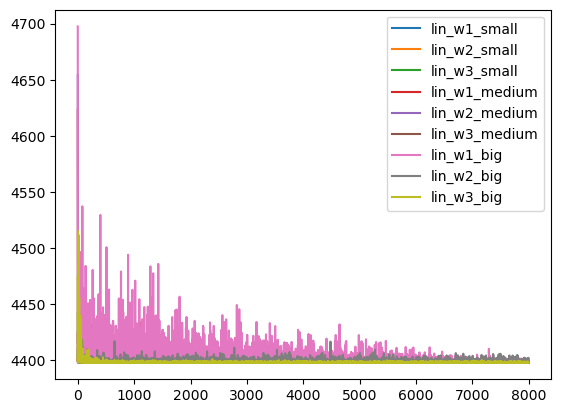

In [11]:
print('Final mse lin_w1_small: ', lin_w1_small.loss_record[-1])
print('Final mse lin_w2_small: ', lin_w2_small.loss_record[-1])
print('Final mse lin_w3_small: ', lin_w3_small.loss_record[-1])
print('Final mse lin_w1_medium: ', lin_w1_medium.loss_record[-1])
print('Final mse lin_w2_medium: ', lin_w2_medium.loss_record[-1])
print('Final mse lin_w3_medium: ', lin_w3_medium.loss_record[-1])
print('Final mse lin_w1_big: ', lin_w1_big.loss_record[-1])
print('Final mse lin_w2_big: ', lin_w2_big.loss_record[-1])
print('Final mse lin_w3_big: ', lin_w3_big.loss_record[-1])
sns.lineplot(lin_w1_small.loss_record, label = 'lin_w1_small')
sns.lineplot(lin_w2_small.loss_record, label = 'lin_w2_small')
sns.lineplot(lin_w3_small.loss_record, label = 'lin_w3_small')
sns.lineplot(lin_w1_medium.loss_record, label = 'lin_w1_medium')
sns.lineplot(lin_w2_medium.loss_record, label = 'lin_w2_medium')
sns.lineplot(lin_w3_medium.loss_record, label = 'lin_w3_medium')
sns.lineplot(lin_w1_big.loss_record, label = 'lin_w1_big')
sns.lineplot(lin_w2_big.loss_record, label = 'lin_w2_big')
sns.lineplot(lin_w3_big.loss_record, label = 'lin_w3_big')

test mse: 4433.837759304952


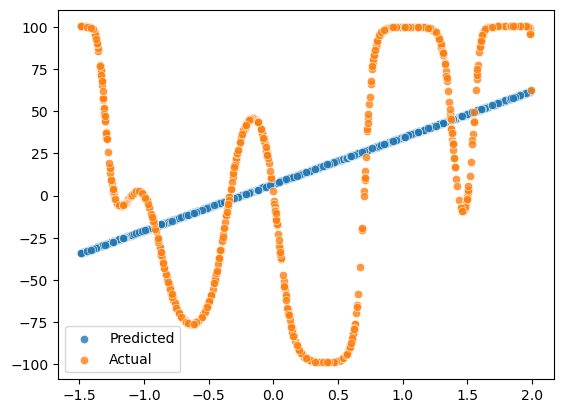

In [12]:
test_regression(multimodal_large_test_X, multimodal_large_test_Y, 1000, lin_w3_big)

In [ ]:
# sigmoida - bardzo zbliżone tempo uczenia i końcowy wynik dla badanych architektór, najsłabsze wyniki końcowe z 3 poważnych architektór (sigmoida, tanh, ReLU), największy model zdawał się móc osiągnąć lepszy wynik przy dalszym uczeniu, ważniejsza liczba warstw niż liczba neuronów w warstwie

Final mse sig_w1_small:  453.7388752371162
Final mse sig_w2_small:  351.23546389666257
Final mse sig_w3_small:  222.75620021284792
Final mse sig_w1_medium:  263.40877647223573
Final mse sig_w2_medium:  195.91945928016858
Final mse sig_w3_medium:  204.47422250984548
Final mse sig_w1_big:  263.12231191878715
Final mse sig_w2_big:  84.33737351495296
Final mse sig_w3_big:  81.70491160124233


<Axes: >

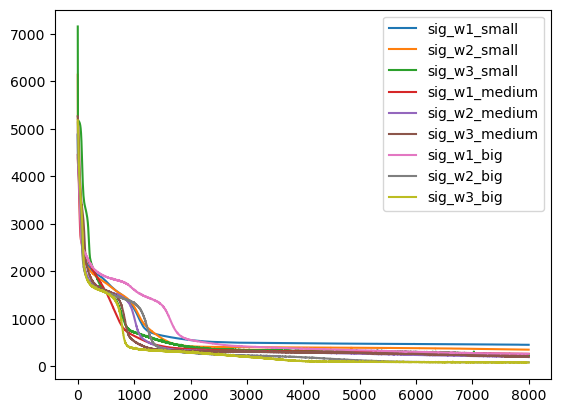

In [9]:
print('Final mse sig_w1_small: ', sig_w1_small.loss_record[-1])
print('Final mse sig_w2_small: ', sig_w2_small.loss_record[-1])
print('Final mse sig_w3_small: ', sig_w3_small.loss_record[-1])
print('Final mse sig_w1_medium: ', sig_w1_medium.loss_record[-1])
print('Final mse sig_w2_medium: ', sig_w2_medium.loss_record[-1])
print('Final mse sig_w3_medium: ', sig_w3_medium.loss_record[-1])
print('Final mse sig_w1_big: ', sig_w1_big.loss_record[-1])
print('Final mse sig_w2_big: ', sig_w2_big.loss_record[-1])
print('Final mse sig_w3_big: ', sig_w3_big.loss_record[-1])
sns.lineplot(sig_w1_small.loss_record, label = 'sig_w1_small')
sns.lineplot(sig_w2_small.loss_record, label = 'sig_w2_small')
sns.lineplot(sig_w3_small.loss_record, label = 'sig_w3_small')
sns.lineplot(sig_w1_medium.loss_record, label = 'sig_w1_medium')
sns.lineplot(sig_w2_medium.loss_record, label = 'sig_w2_medium')
sns.lineplot(sig_w3_medium.loss_record, label = 'sig_w3_medium')
sns.lineplot(sig_w1_big.loss_record, label = 'sig_w1_big')
sns.lineplot(sig_w2_big.loss_record, label = 'sig_w2_big')
sns.lineplot(sig_w3_big.loss_record, label = 'sig_w3_big')

test mse: 74.43808123534103


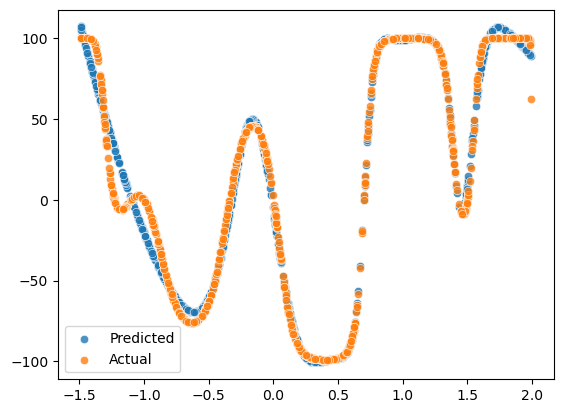

In [10]:
test_regression(multimodal_large_test_X, multimodal_large_test_Y, 1000, sig_w3_big)

In [ ]:
# tangens hiperboliczny - szybka i daleko idąca zbieżność nawet dla najmniejszych modeli, "średnio" najlepsza funkcja aktywacji, ważniejsza liczba warstw niż liczba neuronów w warstwie, ponad połowa architektór zwróciła niemal najlepszy wynik z wszystkich testów, najmniejszy z modeli mógł uczyć się nawet dłużej

Final mse tan_w1_small:  246.161756480252
Final mse tan_w2_small:  8.132953274665619
Final mse tan_w3_small:  83.47086685768325
Final mse tan_w1_medium:  63.68707407836769
Final mse tan_w2_medium:  6.907746670487759
Final mse tan_w3_medium:  6.174231922688451
Final mse tan_w1_big:  61.599226910747205
Final mse tan_w2_big:  6.738728233451045
Final mse tan_w3_big:  6.087965807683572


<Axes: >

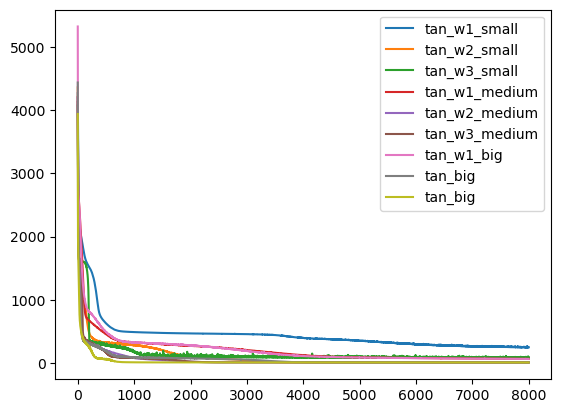

In [13]:
print('Final mse tan_w1_small: ', tan_w1_small.loss_record[-1])
print('Final mse tan_w2_small: ', tan_w2_small.loss_record[-1])
print('Final mse tan_w3_small: ', tan_w3_small.loss_record[-1])
print('Final mse tan_w1_medium: ', tan_w1_medium.loss_record[-1])
print('Final mse tan_w2_medium: ', tan_w2_medium.loss_record[-1])
print('Final mse tan_w3_medium: ', tan_w3_medium.loss_record[-1])
print('Final mse tan_w1_big: ', tan_w1_big.loss_record[-1])
print('Final mse tan_w2_big: ', tan_w2_big.loss_record[-1])
print('Final mse tan_w3_big: ', tan_w3_big.loss_record[-1])
sns.lineplot(tan_w1_small.loss_record, label = 'tan_w1_small')
sns.lineplot(tan_w2_small.loss_record, label = 'tan_w2_small')
sns.lineplot(tan_w3_small.loss_record, label = 'tan_w3_small')
sns.lineplot(tan_w1_medium.loss_record, label = 'tan_w1_medium')
sns.lineplot(tan_w2_medium.loss_record, label = 'tan_w2_medium')
sns.lineplot(tan_w3_medium.loss_record, label = 'tan_w3_medium')
sns.lineplot(tan_w1_big.loss_record, label = 'tan_w1_big')
sns.lineplot(tan_w2_big.loss_record, label = 'tan_big')
sns.lineplot(tan_w3_big.loss_record, label = 'tan_big')

test mse: 3.8678265234706677
test mse: 1.8707285906743536
test mse: 2.3242006305656226


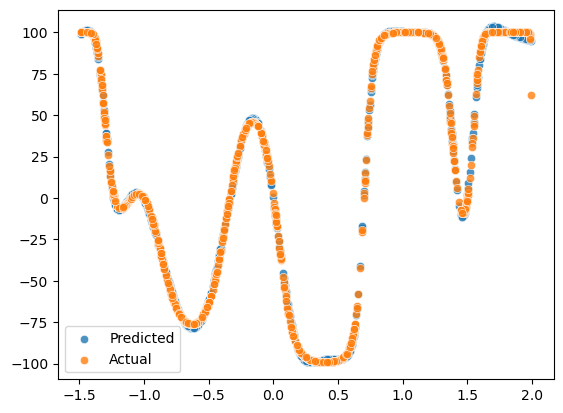

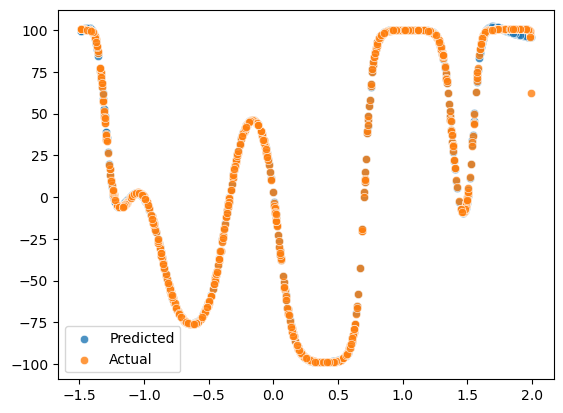

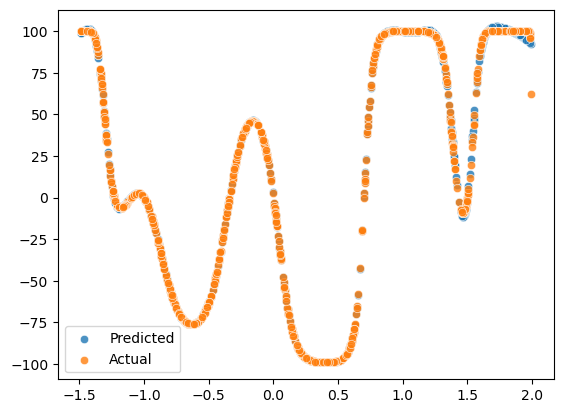

In [16]:
test_regression(multimodal_large_test_X, multimodal_large_test_Y, 1000, tan_w2_small)
test_regression(multimodal_large_test_X, multimodal_large_test_Y, 1000, tan_w3_medium)
test_regression(multimodal_large_test_X, multimodal_large_test_Y, 1000, tan_w3_big)

In [ ]:
# ReLU - wyraźna preferencja większej liczby warstw, z wyjątkiem modeli o małej liczbie neuronów, drugi najlepszy "średni", ale pojedynczy najlepszy (rel_w3_medium) wynik pod względem funkcji aktywacji, liczba warstw ważniejsza niż liczba neuronów w warstwie, największe dysproporcje między architekturami

Final mse rel_w1_small:  578.1420968466789
Final mse rel_w2_small:  2352.046368050477
Final mse rel_w3_small:  395.281340349287
Final mse rel_w1_medium:  1631.5935402863674
Final mse rel_w2_medium:  387.5882773548083
Final mse rel_w3_medium:  5.676038538233876
Final mse rel_w1_big:  1438.6770367138422
Final mse rel_w2_big:  11.35376355777285
Final mse rel_w3_big:  7.8211343567611085


<Axes: >

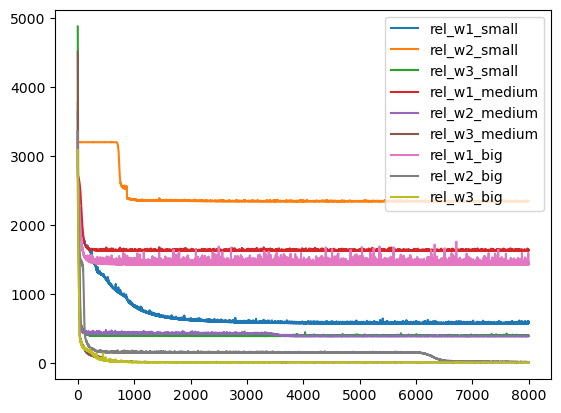

In [18]:
print('Final mse rel_w1_small: ', rel_w1_small.loss_record[-1])
print('Final mse rel_w2_small: ', rel_w2_small.loss_record[-1])
print('Final mse rel_w3_small: ', rel_w3_small.loss_record[-1])
print('Final mse rel_w1_medium: ', rel_w1_medium.loss_record[-1])
print('Final mse rel_w2_medium: ', rel_w2_medium.loss_record[-1])
print('Final mse rel_w3_medium: ', rel_w3_medium.loss_record[-1])
print('Final mse rel_w1_big: ', rel_w1_big.loss_record[-1])
print('Final mse rel_w2_big: ', rel_w2_big.loss_record[-1])
print('Final mse rel_w3_big: ', rel_w3_big.loss_record[-1])
sns.lineplot(rel_w1_small.loss_record, label = 'rel_w1_small')
sns.lineplot(rel_w2_small.loss_record, label = 'rel_w2_small')
sns.lineplot(rel_w3_small.loss_record, label = 'rel_w3_small')
sns.lineplot(rel_w1_medium.loss_record, label = 'rel_w1_medium')
sns.lineplot(rel_w2_medium.loss_record, label = 'rel_w2_medium')
sns.lineplot(rel_w3_medium.loss_record, label = 'rel_w3_medium')
sns.lineplot(rel_w1_big.loss_record, label = 'rel_w1_big')
sns.lineplot(rel_w2_big.loss_record, label = 'rel_w2_big')
sns.lineplot(rel_w3_big.loss_record, label = 'rel_w3_big')

test mse: 3.2493033528039055
test mse: 3.4341063107461145


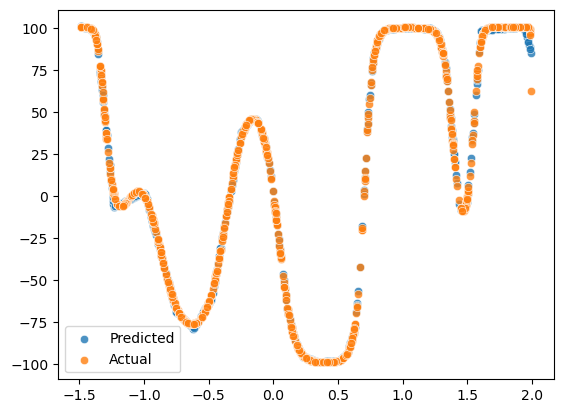

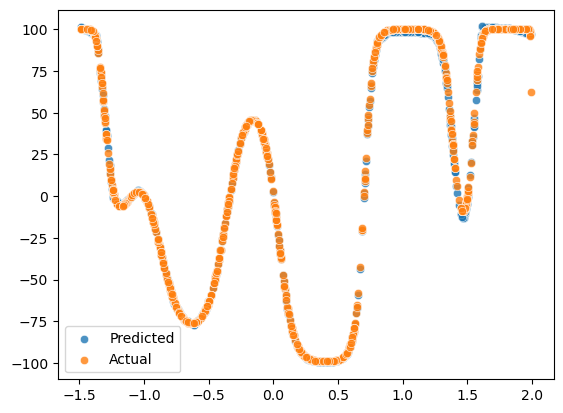

In [19]:
test_regression(multimodal_large_test_X, multimodal_large_test_Y, 1000, rel_w3_medium)
test_regression(multimodal_large_test_X, multimodal_large_test_Y, 1000, rel_w3_big)

In [ ]:
# Pozwalam sobie na wybranie 3, a nie dwóch najlepszych modeli z racji, że moje testy pokazały, że każdy z najlepszej trójki korzystał z innej funkcji aktywacji i próba wyciśnięcia z nich jak najwięcej może być ciekawa. Będą to: rel_w3_medium, tan_w3_big oraz sig_w3_big.

steps_large_train size:  10000
steps_large_test size:  1000
rings3_train size:  1500
rings3_test size:  2000
rings5_train size:  1250
rings5_test size:  2000


<Axes: >

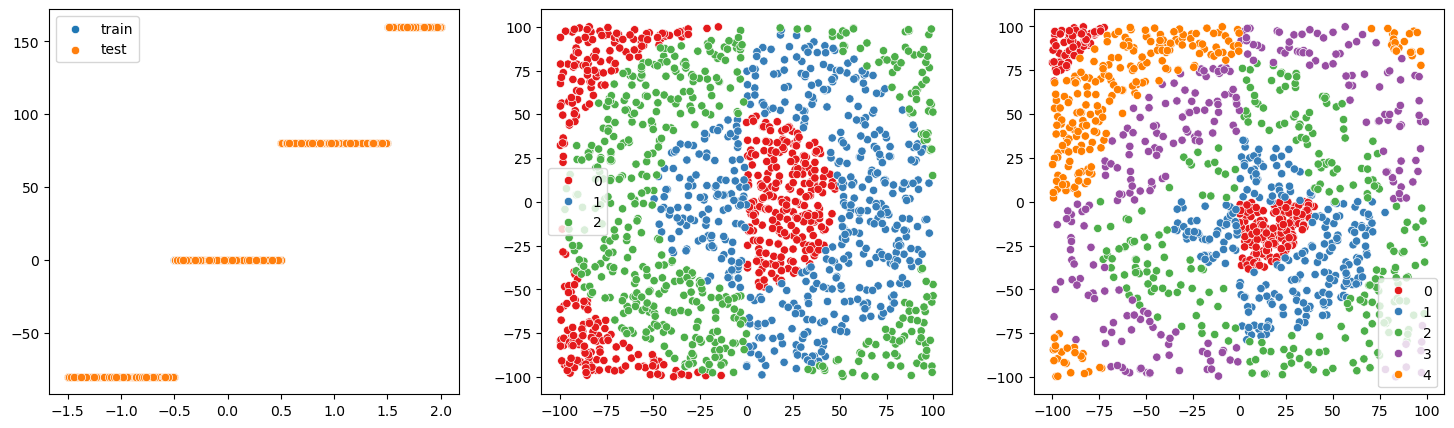

In [23]:
steps_large_train = pd.read_csv('../data/regression/steps-large-training.csv')[['x', 'y']]
rings3_train = pd.read_csv('../data/classification/rings3-regular-training.csv')[['x', 'y', 'c']]
rings5_train = pd.read_csv('../data/classification/rings5-regular-training.csv')[['x', 'y', 'c']]

steps_large_test = pd.read_csv('../data/regression/steps-large-test.csv')[['x', 'y']]
rings3_test = pd.read_csv('../data/classification/rings3-regular-test.csv')[['x', 'y', 'c']]
rings5_test = pd.read_csv('../data/classification/rings5-regular-test.csv')[['x', 'y', 'c']]

steps_large_train_X = np.array(steps_large_train['x'])
steps_large_train_Y = np.array(steps_large_train['y'])
steps_large_test_X = np.array(steps_large_test['x'])
steps_large_test_Y = np.array(steps_large_test['y'])

rings3_train_X = np.array(rings3_train['x'])
rings3_train_Y = np.array(rings3_train['y'])
rings3_train_C = np.array(rings3_train['c'])
rings3_test_X = np.array(rings3_test['x'])
rings3_test_Y = np.array(rings3_test['y'])
rings3_test_C = np.array(rings3_test['c'])

rings5_train_X = np.array(rings5_train['x'])
rings5_train_Y = np.array(rings5_train['y'])
rings5_train_C = np.array(rings5_train['c'])
rings5_test_X = np.array(rings5_test['x'])
rings5_test_Y = np.array(rings5_test['y'])
rings5_test_C = np.array(rings5_test['c'])

print('steps_large_train size: ', len(steps_large_train))
print('steps_large_test size: ', len(steps_large_test))
print('rings3_train size: ', len(rings3_train))
print('rings3_test size: ', len(rings3_test))
print('rings5_train size: ', len(rings5_train))
print('rings5_test size: ', len(rings5_test))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(x=steps_large_train_X, y=steps_large_train_Y, label = 'train', ax=axes[0])
sns.scatterplot(x=steps_large_test_X, y=steps_large_test_Y, label = 'test', ax=axes[0])
sns.scatterplot(x=rings3_train_X, y=rings3_train_Y, hue=rings3_train_C, ax=axes[1], palette='Set1')
sns.scatterplot(x=rings5_train_X, y=rings5_train_Y, hue=rings5_train_C, ax=axes[2], palette='Set1')

In [ ]:
# setps

Final loss score:  10.595984796887569
test mse: 6.0680937073545484


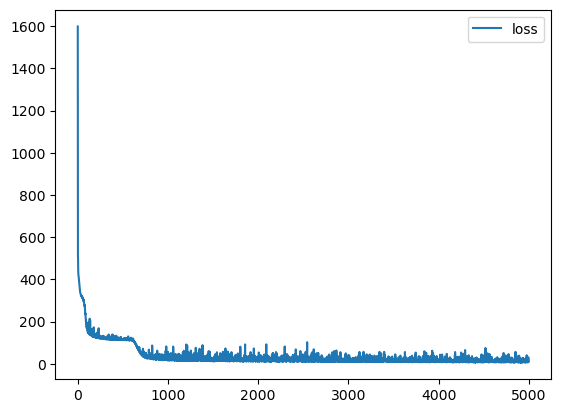

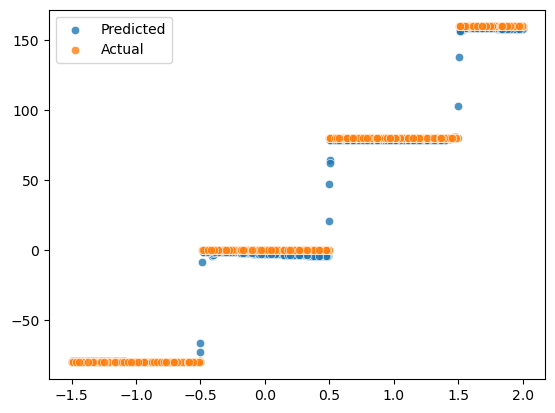

In [49]:
rel_w3_medium_setps = network(architecture = np.array([1, 15, 15, 15, 1]), 
                        activation_functions = [None, ReLU, ReLU, ReLU, linear], 
                        activation_derivatives = [None, ReLU_derivative, ReLU_derivative, ReLU_derivative, linear_derivative], 
                        initiation_method = 'xavier')

rel_w3_medium_setps.learn(task = 'regression',
                     x = steps_large_train_X,
                     y = steps_large_train_Y,
                     epochs_number = 5000,
                     step = 0.075,
                     momentum_dumping = 0.90,
                     batch_size = 1000)

print('Final loss score: ', rel_w3_medium_setps.loss_record[-1])
sns.lineplot(rel_w3_medium_setps.loss_record, label = 'loss')

test_regression(x=steps_large_test_X, y=steps_large_test_Y, size=1000, network=rel_w3_medium_setps)

Final loss score:  13.793537593559703
test mse: 11.166285107880837


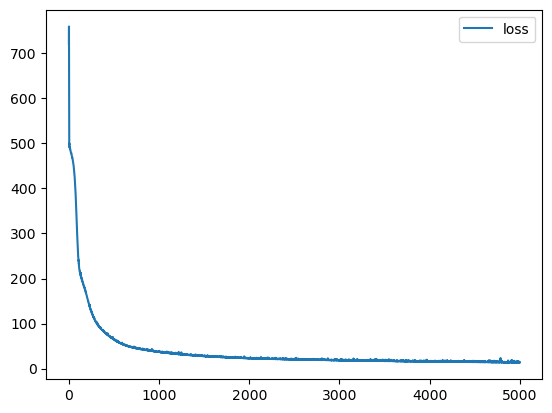

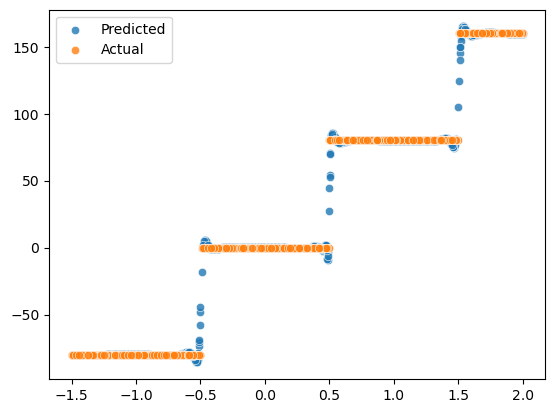

In [51]:
tan_w3_big_setps = network(architecture = np.array([1, 30, 30, 30, 1]), 
                        activation_functions = [None, tanh, tanh, tanh, linear], 
                        activation_derivatives = [None, tanh_derivative, tanh_derivative, tanh_derivative, linear_derivative], 
                        initiation_method = 'xavier')

tan_w3_big_setps.learn(task = 'regression',
                     x = steps_large_train_X,
                     y = steps_large_train_Y,
                     epochs_number = 5000,
                     step = 0.025,
                     momentum_dumping = 0.90,
                     batch_size = 1000)

print('Final loss score: ', tan_w3_big_setps.loss_record[-1])
sns.lineplot(tan_w3_big_setps.loss_record, label = 'loss')

test_regression(x=steps_large_test_X, y=steps_large_test_Y, size=1000, network=tan_w3_big_setps)

Final loss score:  18.695645086876308
test mse: 15.049969413104929


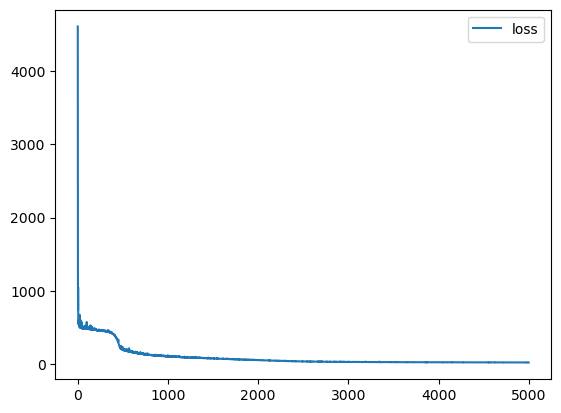

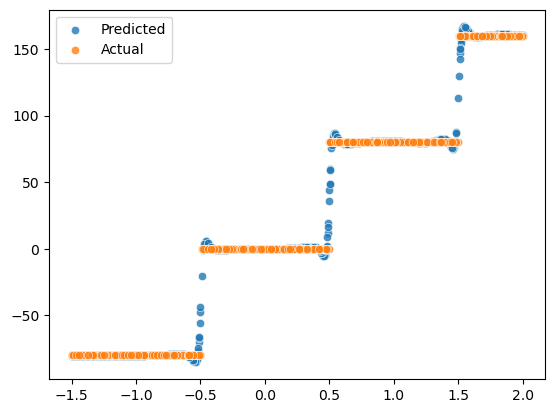

In [56]:
sin_w3_big_setps = network(architecture = np.array([1, 30, 30, 30, 1]), 
                        activation_functions = [None, sigmoid, sigmoid, sigmoid, linear], 
                        activation_derivatives = [None, sigmoid_derivative, sigmoid_derivative, sigmoid_derivative, linear_derivative], 
                        initiation_method = 'xavier')

sin_w3_big_setps.learn(task = 'regression',
                     x = steps_large_train_X,
                     y = steps_large_train_Y,
                     epochs_number = 5000,
                     step = 0.25,
                     momentum_dumping = 0.90,
                     batch_size = 1000)

print('Final loss score: ', sin_w3_big_setps.loss_record[-1])
sns.lineplot(sin_w3_big_setps.loss_record, label = 'loss')

test_regression(x=steps_large_test_X, y=steps_large_test_Y, size=1000, network=sin_w3_big_setps)

In [ ]:
# rings3

Final f1_score:  0.9984974954412836
Final loss score:  0.010841143815060614
test cross entropy: 0.3152396488339384
test f-measure: 0.9311345985354234


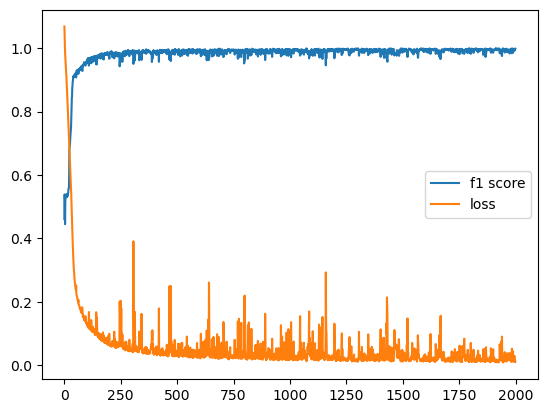

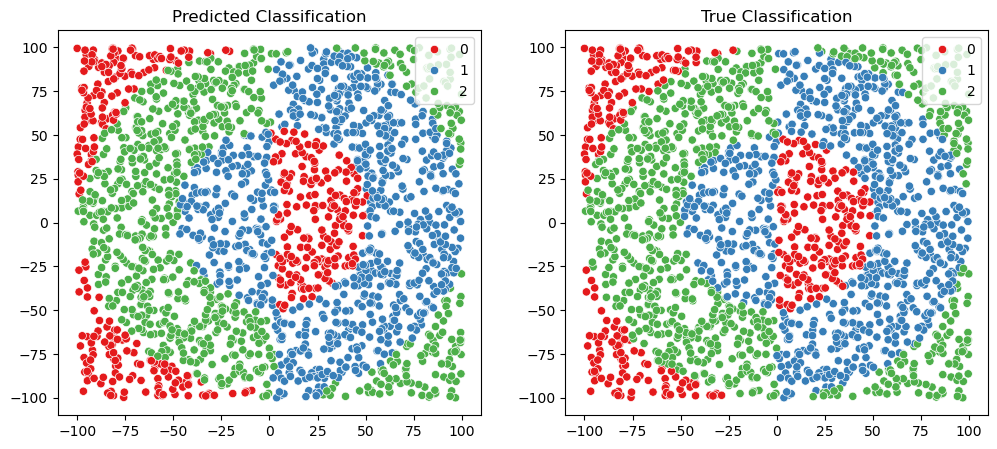

In [38]:
rel_w3_medium_rings3 = network(architecture = np.array([2, 15, 15, 15, 3]), 
                        activation_functions = [None, ReLU, ReLU, ReLU, softmax], 
                        activation_derivatives = [None, ReLU_derivative, ReLU_derivative, ReLU_derivative, None], 
                        initiation_method = 'xavier')

rel_w3_medium_rings3.learn(task = 'classification',
                     x = [rings3_train_X, rings3_train_Y],
                     y = rings3_train_C,
                     epochs_number = 2000,
                     step = 0.01,
                     momentum_dumping = 0.90,
                     batch_size = 150)

print('Final f1_score: ', rel_w3_medium_rings3.f1_score[-1])
print('Final loss score: ', rel_w3_medium_rings3.loss_record[-1])
sns.lineplot(rel_w3_medium_rings3.f1_score, label = 'f1 score')
sns.lineplot(rel_w3_medium_rings3.loss_record, label = 'loss')

test_classification([rings3_test_X, rings3_test_Y], rings3_test_C, rel_w3_medium_rings3)

Final f1_score:  0.9873360934566173
Final loss score:  0.04086028192104114
test cross entropy: 0.3373992470437238
test f-measure: 0.9238769384825035


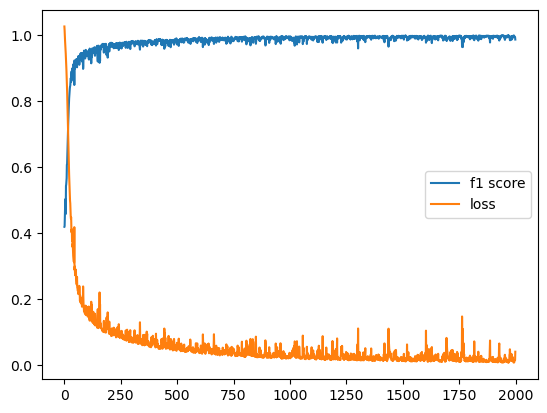

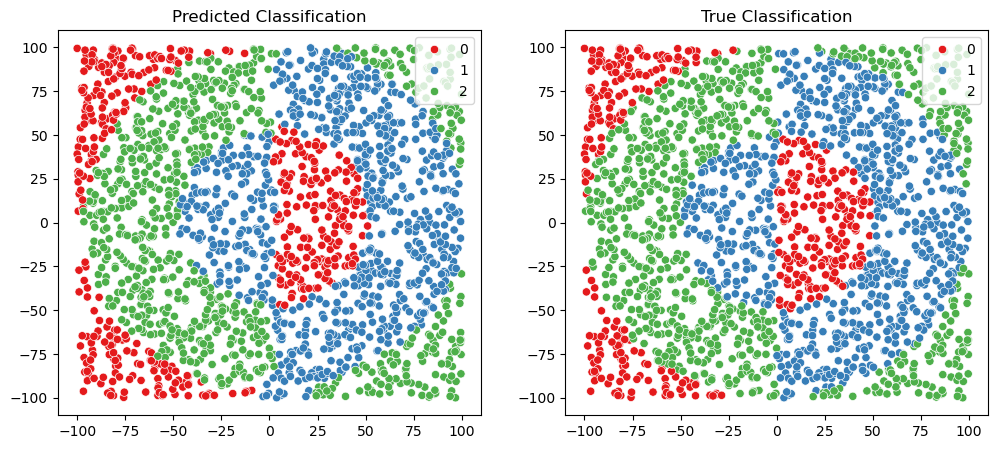

In [52]:
tan_w3_big_rings3 = network(architecture = np.array([2, 30, 30, 30, 3]),
                        activation_functions = [None, tanh, tanh, tanh, softmax], 
                        activation_derivatives = [None, tanh_derivative, tanh_derivative, tanh_derivative, None], 
                        initiation_method = 'xavier')

tan_w3_big_rings3.learn(task = 'classification',
                     x = [rings3_train_X, rings3_train_Y],
                     y = rings3_train_C,
                     epochs_number = 2000,
                     step = 0.01,
                     momentum_dumping = 0.90,
                     batch_size = 150)

print('Final f1_score: ', tan_w3_big_rings3.f1_score[-1])
print('Final loss score: ', tan_w3_big_rings3.loss_record[-1])
sns.lineplot(tan_w3_big_rings3.f1_score, label = 'f1 score')
sns.lineplot(tan_w3_big_rings3.loss_record, label = 'loss')

test_classification([rings3_test_X, rings3_test_Y], rings3_test_C, tan_w3_big_rings3)

Final f1_score:  0.9920516110133915
Final loss score:  0.029534108402259368
test cross entropy: 0.2934124092572175
test f-measure: 0.9140636591516178


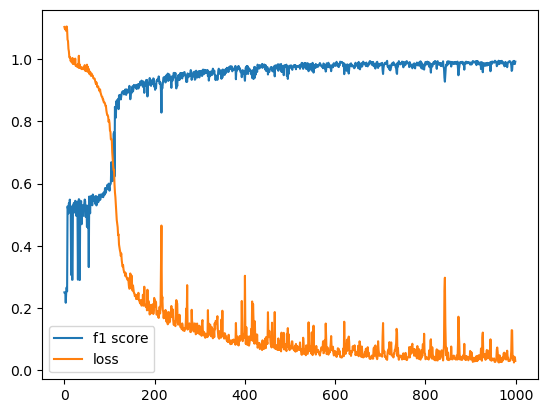

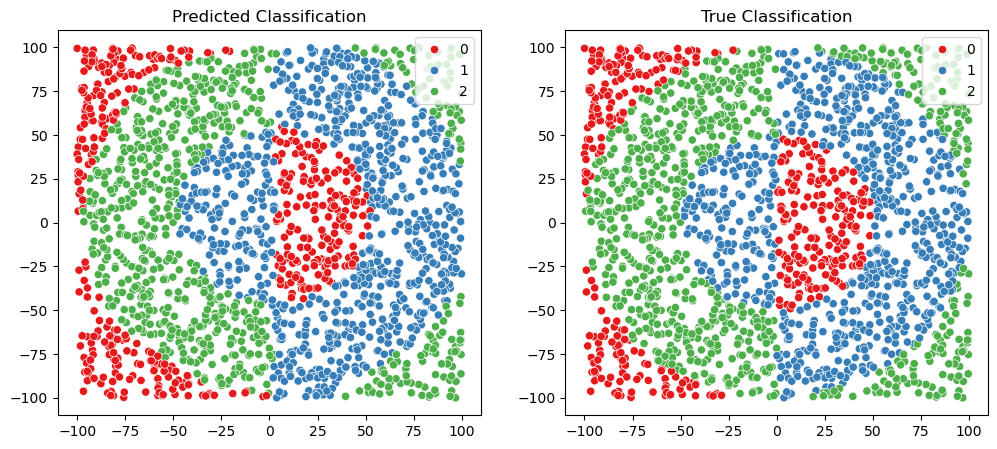

In [53]:
sig_w3_big_rings3 = network(architecture = np.array([2, 30, 30, 30, 3]),
                        activation_functions = [None, sigmoid, sigmoid, sigmoid, softmax], 
                        activation_derivatives = [None, sigmoid_derivative, sigmoid_derivative, sigmoid_derivative, None], 
                        initiation_method = 'xavier')

sig_w3_big_rings3.learn(task = 'classification',
                     x = [rings3_train_X, rings3_train_Y],
                     y = rings3_train_C,
                     epochs_number = 1000,
                     step = 0.1,
                     momentum_dumping = 0.90,
                     batch_size = 150)

print('Final f1_score: ', sig_w3_big_rings3.f1_score[-1])
print('Final loss score: ', sig_w3_big_rings3.loss_record[-1])
sns.lineplot(sig_w3_big_rings3.f1_score, label = 'f1 score')
sns.lineplot(sig_w3_big_rings3.loss_record, label = 'loss')

test_classification([rings3_test_X, rings3_test_Y], rings3_test_C, sig_w3_big_rings3)

In [ ]:
# rings5

Final f1_score:  0.9544099531400634
Final loss score:  0.19214925714536157
test cross entropy: 0.6307838537956917
test f-measure: 0.7125076349175369


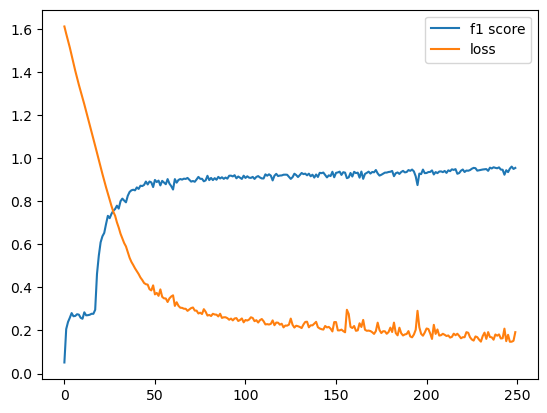

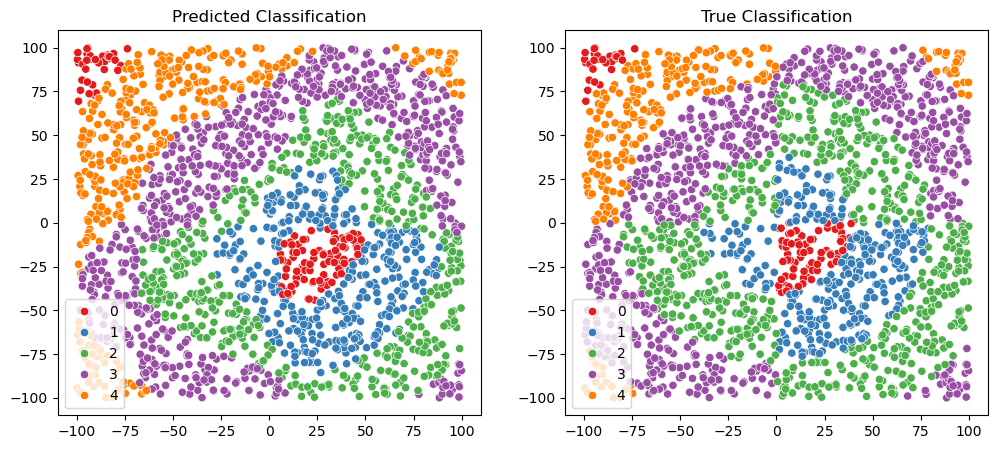

In [57]:
rel_w3_medium_rings5 = network(architecture = np.array([2, 15, 15, 15, 5]), 
                        activation_functions = [None, ReLU, ReLU, ReLU, softmax], 
                        activation_derivatives = [None, ReLU_derivative, ReLU_derivative, ReLU_derivative, None], 
                        initiation_method = 'xavier')

rel_w3_medium_rings5.learn(task = 'classification',
                     x = [rings5_train_X, rings5_train_Y],
                     y = rings5_train_C,
                     epochs_number = 250,
                     step = 0.01,
                     momentum_dumping = 0.90,
                     batch_size = 125)

print('Final f1_score: ', rel_w3_medium_rings5.f1_score[-1])
print('Final loss score: ', rel_w3_medium_rings5.loss_record[-1])
sns.lineplot(rel_w3_medium_rings5.f1_score, label = 'f1 score')
sns.lineplot(rel_w3_medium_rings5.loss_record, label = 'loss')

test_classification([rings5_test_X, rings5_test_Y], rings5_test_C, rel_w3_medium_rings5)

Final f1_score:  0.989037598957146
Final loss score:  0.078771836011746
test cross entropy: 0.7312963788077216
test f-measure: 0.6762949693485919


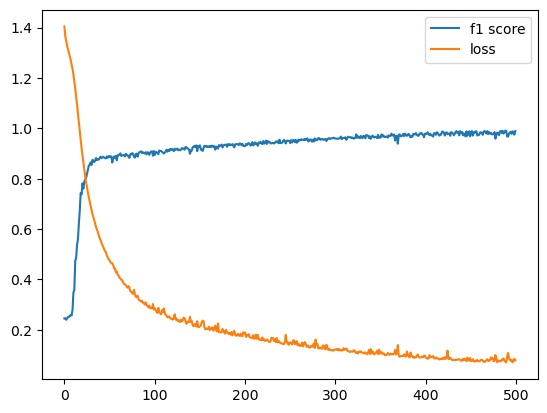

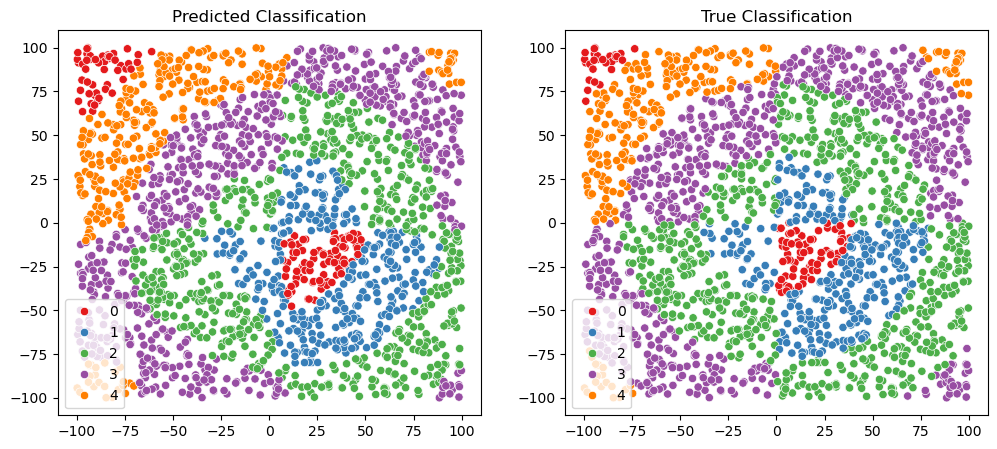

In [54]:
tan_w3_big_rings5 = network(architecture = np.array([2, 30, 30, 30, 5]),
                        activation_functions = [None, tanh, tanh, tanh, softmax], 
                        activation_derivatives = [None, tanh_derivative, tanh_derivative, tanh_derivative, None], 
                        initiation_method = 'xavier')

tan_w3_big_rings5.learn(task = 'classification',
                     x = [rings5_train_X, rings5_train_Y],
                     y = rings5_train_C,
                     epochs_number = 500,
                     step = 0.01,
                     momentum_dumping = 0.90,
                     batch_size = 125)

print('Final f1_score: ', tan_w3_big_rings5.f1_score[-1])
print('Final loss score: ', tan_w3_big_rings5.loss_record[-1])
sns.lineplot(tan_w3_big_rings5.f1_score, label = 'f1 score')
sns.lineplot(tan_w3_big_rings5.loss_record, label = 'loss')

test_classification([rings5_test_X, rings5_test_Y], rings5_test_C, tan_w3_big_rings5)

Final f1_score:  0.9393791171442178
Final loss score:  0.16268869913275472
test cross entropy: 0.6243176065118754
test f-measure: 0.6603763356166886


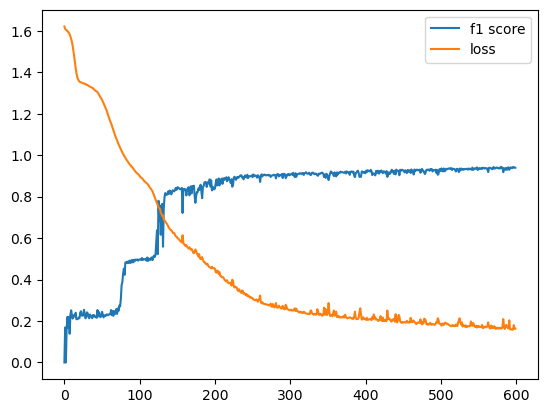

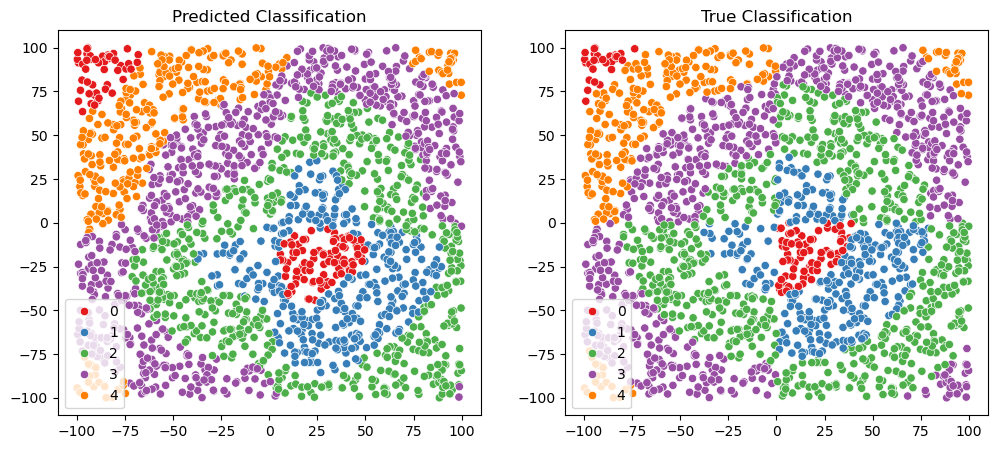

In [60]:
sig_w3_big_rings5 = network(architecture = np.array([2, 30, 30, 30, 5]),
                        activation_functions = [None, sigmoid, sigmoid, sigmoid, softmax], 
                        activation_derivatives = [None, sigmoid_derivative, sigmoid_derivative, sigmoid_derivative, None], 
                        initiation_method = 'xavier')

sig_w3_big_rings5.learn(task = 'classification',
                     x = [rings5_train_X, rings5_train_Y],
                     y = rings5_train_C,
                     epochs_number = 600,
                     step = 0.05,
                     momentum_dumping = 0.90,
                     batch_size = 125)

print('Final f1_score: ', sig_w3_big_rings5.f1_score[-1])
print('Final loss score: ', sig_w3_big_rings5.loss_record[-1])
sns.lineplot(sig_w3_big_rings5.f1_score, label = 'f1 score')
sns.lineplot(sig_w3_big_rings5.loss_record, label = 'loss')

test_classification([rings5_test_X, rings5_test_Y], rings5_test_C, sig_w3_big_rings5)